## Introduction to Time Series Forecasting

Una serie de tiempo es una secuencia tomada en sucesivos puntos equidistantes en el tiempo. Por lo tanto, es una secuencia de datos de tiempo discreto [Ref](https://en.wikipedia.org/wiki/Time_series), [Ref 2](https://www.youtube.com/watch?v=e8Yw4alG16Q). 

### Atributos de las series de tiempo
* Está sobre un intervalo de tiempo continuo
* Hay mediciones secuenciales en ese intervalo.
* Hay un espacio igual entre cada dos mediciones consecutivas
* Cada unidad de tiempo dentro del intervalo de tiempo tiene como máximo un punto de datos

**Ejemplo**: https://www.youtube.com/watch?time_continue=57&v=R8Lxt0ooQ9I&feature=emb_logo

### Componentes de una serie de tiempo
**Tendencia**: cambio gradual hacia valores más grandes o pequeños en el tiempo.

<img src = "../imgs/trend.png" width=350>

**Estacionalidad:** una serie que exhibe un patrón que se repite en intervalos de tiempo fijos.

<img src = "../imgs/seasonality.png" width=350>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6


In [2]:
data = pd.read_csv('../data/AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


Convertimos la columna Month un objeto de serie temporal y la usaremos como nuestro índice


In [3]:
from datetime import datetime
#con = data['Month']
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [4]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [5]:
## Algunas propiedades de las series.
ts[datetime(1949,1,1)]

112

In [6]:
## Obtenga el rango entre 1949-01-01 y 1949-05-01
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [7]:
## Obtenga todos los datos de 1949 de ts
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

## ESTACIONARIEDAD (STATIONARITY)

Para aplicar un modelo de serie temporal, es importante que la serie sea estacionaria; es decir, todas sus propiedades estadísticas (media, varianza) permanecen constantes en el tiempo. 

En la práctica, podemos suponer que la serie es estacionaria si tiene propiedades estadísticas constantes a lo largo del tiempo:

a. Media constante
b. Varianza constante
c. Una auto co-varianza que no depende del tiempo

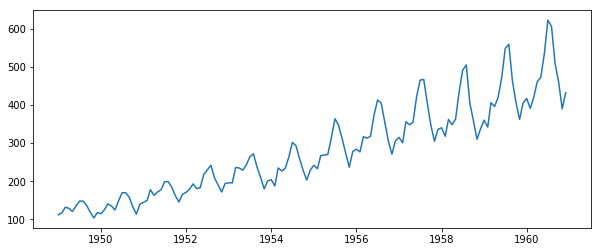

In [8]:
plt.figure(figsize=(10,4))
plt.plot(ts)

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    ## Prueba de Dickey-fuller: esta es una de las pruebas estadísticas para verificar la estacionariedad. 
    #Primero consideramos la hipótesis nula: la serie temporal no es estacionaria. 
    #El resultado del resto contendrá la estadística de prueba y el valor crítico para diferentes niveles de 
    #confianza. La idea es tener estadísticas de prueba inferiores al valor crítico, en este caso podemos rechazar 
    #la hipótesis nula y decir que esta serie de tiempo es estacionaria
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

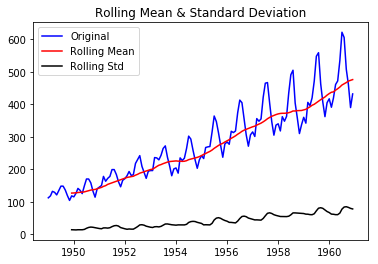

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(ts)

Esta serie no es estacionario porque:
* La media está aumentando a pesar de que el estándar es pequeño.
* p-value > critical value

## Convertir la serie de tiempo a estacionaria

* Tendencia (trend): media no constante
* Estacionalidad: variación en plazos específicos

La idea básica es modelar la tendencia y la estacionalidad en esta serie, para poderla eliminarla y hacer que la serie sea estacionaria. A partir de ella, se aplican pronósticos estadísticos usadas en las series estacionarias. Y finalmente podemos convertir los valores pronosticados en originales aplicando las restricciones de tendencia y estacionalidad a las que separamos previamente.

### Tendencia

El primer paso es reducir la tendencia utilizando una transformación (en este caso hay una fuerte tendencia positiva). Estas transformaciones básicamente penalizan los valores más grandes más que los más pequeños. En este caso usaremos la transformación logarítmica.

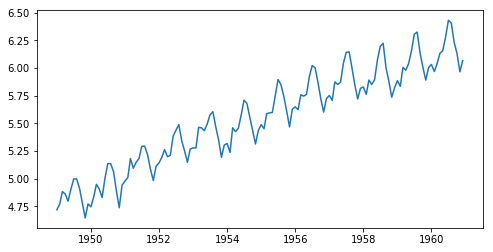

In [11]:
ts_log = np.log(ts)
plt.figure(figsize=(8,4))
plt.plot(ts_log)

Existen algunos métodos para modelar estas tendencias y luego eliminarlas de la serie. Tenemos por ejemplo:
* Smoothing: usando media móvil
* Aggression: tomando la media de un cierto período de tiempo (año / mes)

### Smoothing
Usualmente se toman las últimas instancias (estimaciones continuas) 

#### Moving average 

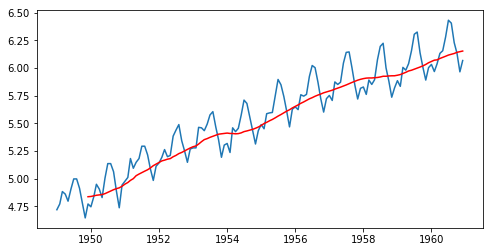

In [12]:
rolmean = ts_log.rolling(window=12).mean()  ###media del ventaneo??
plt.figure(figsize = (8,4))
plt.plot(ts_log)
plt.plot(rolmean, 'red')

In [13]:
# Now subtract the rolling mean from the original series.
ts_log_rolmean_diff = ts_log- rolmean
ts_log_rolmean_diff.head(13)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
Name: #Passengers, dtype: float64

In [14]:
print (np.log(ts['1949-12-01']),np.log(np.mean(ts['1949-01-01':'1949-12-01'])))

4.770684624465665 4.841558964052322


In [15]:
ts_log_rolmean_diff.dropna(inplace=True)
ts_log_rolmean_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

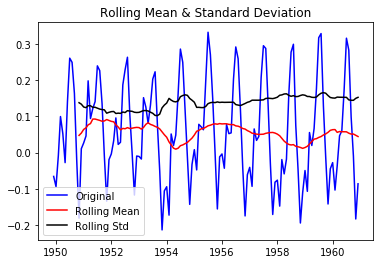

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
test_stationarity(ts_log_rolmean_diff)

De lo anterior, tenemos que:

• Los valores calculados por el rolling varían ligeramente, pero no hay una tendencia específica.

• Las estadísticas de prueba son más pequeñas que los valores críticos del 5%. Eso nos dice que estamos 95% seguros de que esta serie es estacionaria.

**Exponential Decay Transformation**

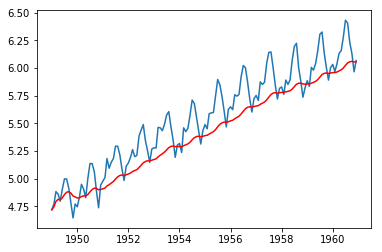

In [17]:
exp_emwa = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(exp_emwa, color='red')

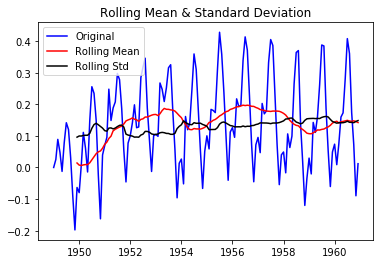

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
ts_log_emwa_diff = ts_log- exp_emwa
test_stationarity(ts_log_emwa_diff)

Es estacionario porque:

• Los valores de rolling tienen menos variaciones en la media y la desviación estándar en magnitud.

• El estadístico de prueba es menor al 1% del valor crítico. Entonces podemos decir que estamos casi 99% seguros de que esto es estacionario.

### Estacionalidad (junto con tendencia)

La mayoría de las series temporales tienen tendencias junto con la estacionalidad. Hay dos métodos comunes para eliminar la tendencia y la estacionalidad, que son:

* Diferenciación: tomando la diferencia usando el retraso de tiempo
* Descomposición: modelar tanto la tendencia como la estacionalidad, luego eliminarlos

**Time Shift Transformation**

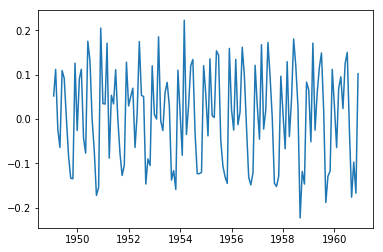

In [19]:
ts_log_diff_shifting = ts_log - ts_log.shift()
plt.plot(ts_log_diff_shifting)

**Ejercicio: Qué hace la función shift?**

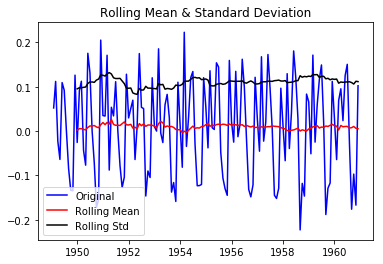

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
ts_log_diff_shifting.dropna(inplace=True)
test_stationarity(ts_log_diff_shifting)

Es estacionario porque:

• Los valores de rolling tienen menos variaciones en la media y la desviación estándar en magnitud.
• La estadística de prueba es inferior al 10% de los valores críticos, por lo que podemos estar seguros al 90% de que esto es estacionario.

**Decomposición:** Aquí se modela tanto la tendencia como la estacionalidad, luego se devuelve la parte restante de la serie temporal. 

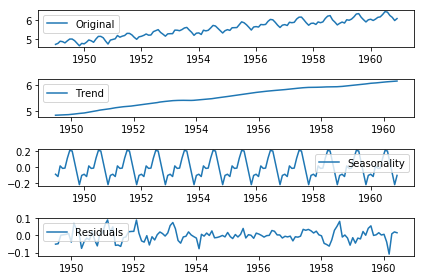

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()


Elimine la tendencia y la estacionalidad de la serie de tiempo y ahora podemos usar los valores residuales.

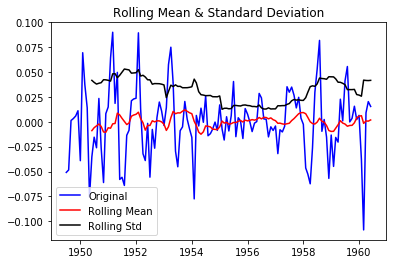

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [22]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

Esto es estacionario porque:

• La estadística de prueba es inferior al 1% de los valores críticos.

• Las variaciones medias y estándar tienen pequeñas variaciones con el tiempo.

### Forecasting a Time Series

**Auto Regressive Integrated Moving Average(ARIMA) [Ref](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)**

En estadística y econometría, y en particular en análisis de series de tiempo, un modelo de promedio móvil integrado autorregresivo (ARIMA) es una generalización de un modelo de promedio móvil autorregresivo (ARMA). Ambos modelos se ajustan a datos de series de tiempo para comprender mejor los datos o para predecir puntos futuros en la serie (pronóstico).

Los modelos ARIMA generalmente se denominan ARIMA (p, d, q) donde los parámetros p, d y q son enteros no negativos.

* p: Este es el número de términos AR (Regresivo automático). Ejemplo: si p es 3, el predictor para y (t) será y (t-1), y (t-2), y (t-3)

* q es el orden del modelo de promedio móvil

* d es el grado de diferenciación (el número de veces que los datos han restado valores anteriores)

Cuando dos de los tres términos son ceros, se puede hacer referencia al modelo en función del parámetro distinto de cero, eliminando "AR", "I" o "MA" del acrónimo que describe el modelo. Por ejemplo, ARIMA (1,0,0) es AR (1), ARIMA (0,1,0) es I (1) y ARIMA (0,0,1) es MA (1)

**Pero cómo definimos los valores p y q en ARIMA**

**Función de autocorrelación (ACF):** solo mide la correlación entre dos consecutivos (versión retrasada). ejemplo en el retraso 4, ACF comparará las series en la instancia de tiempo t1 ... t2 con las series en la instancia t1–4 ... t2–4

**Función de autocorrelación parcial (PACF):** se utiliza para medir el grado de asociación entre y(t) e y(t-p)

In [23]:
##preparar la explicación del ACF y del PACF

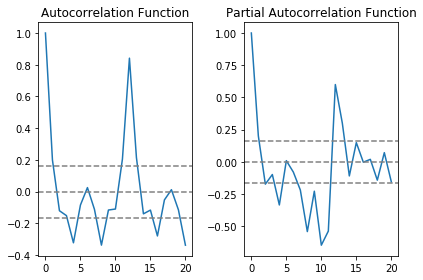

In [24]:
#ACF & PACF plots

lag_acf = acf(ts_log_diff_shifting, nlags=20)
lag_pacf = pacf(ts_log_diff_shifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

In [30]:
temp = np.arange(0,21)
temp

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

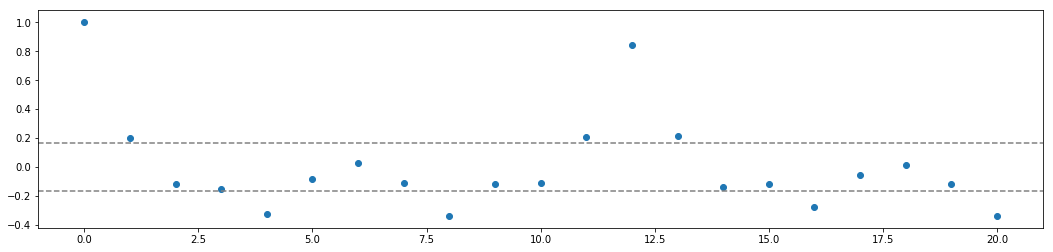

In [36]:
plt.figure(figsize=(18,4))
plt.scatter(temp, lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')


Text(0.5, 1.0, 'Partial Autocorrelation Function')

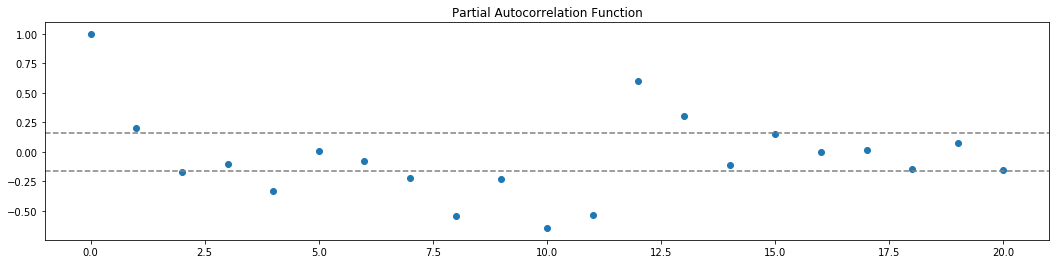

In [37]:
plt.figure(figsize=(18,4))
plt.scatter(temp, lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

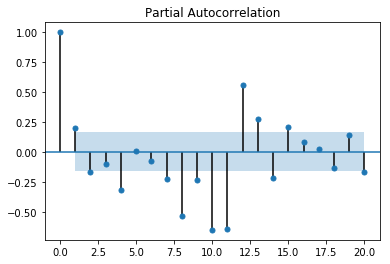

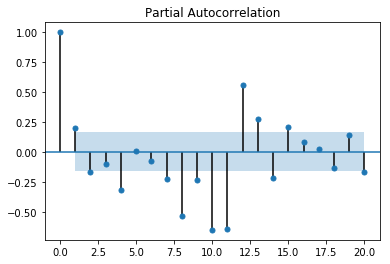

In [40]:
plot_pacf(ts_log_diff_shifting, lags=20)

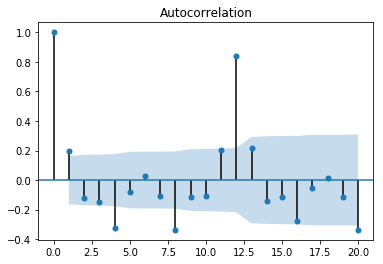

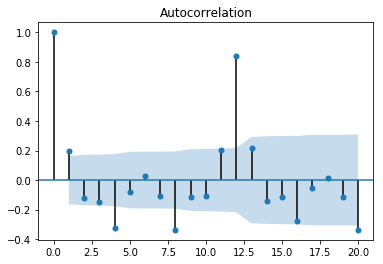

In [42]:
plot_acf(ts_log_diff_shifting, lags=20)

**Ejercicio:** en qué punto del eje x, la curva sobrepasa el intervalo de confianza superior en ambos gráficos?

• p: la primera vez que el PACF cruza el intervalo de confianza superior, p = 2.

• q: la primera vez que el ACF cruza el intervalo de confianza superior, q = 2.

**Construcción de modelos**

**AR**

/Users/franchesca/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/franchesca/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/franchesca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/franchesca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

Plotting AR model


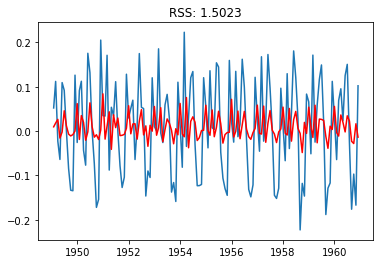

In [24]:
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_log_diff_shifting)**2))
print('Plotting AR model')


**MA**

/Users/franchesca/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/franchesca/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


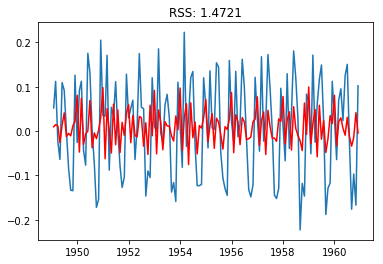

In [25]:
model = ARIMA(ts_log, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff_shifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - ts_log_diff_shifting)**2))
print('Plotting AR model')


**AR+I+MA**

/Users/franchesca/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/franchesca/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


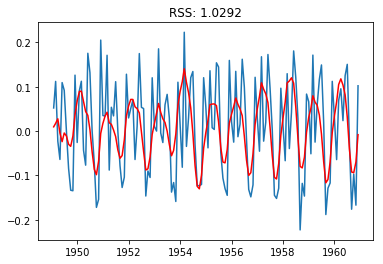

In [26]:
model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - ts_log_diff_shifting)**2))
print('Plotting AR model')


**PASO FINAL: Predicción y transformaciones inversas**

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [28]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [29]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

In [32]:
predictions_ARIMA_log.shape

(144,)

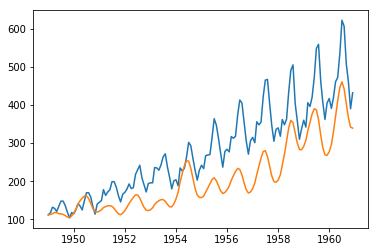

In [31]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)

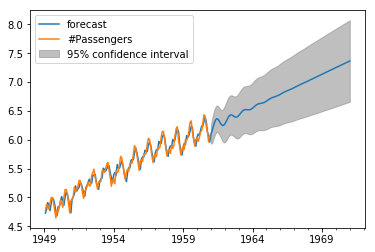

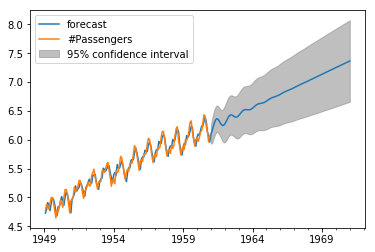

In [32]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
#x=results_ARIMA.forecast(steps=120)

In [33]:
results_ARIMA.forecast(steps=120)

(array([6.09553392, 6.15281404, 6.22442971, 6.2924111 , 6.34164728,
        6.36359373, 6.35784694, 6.33139307, 6.29597538, 6.26447706,
        6.24738316, 6.25025162, 6.2727583 , 6.30940312, 6.35151498,
        6.38988664, 6.41727391, 6.43011062, 6.42906692, 6.41842486,
        6.40456146, 6.39403602, 6.39183068, 6.40019491, 6.41833684,
        6.44295405, 6.46937438, 6.49293991, 6.51024124, 6.51989035,
        6.52267576, 6.52112379, 6.51864514, 6.51853674, 6.52311907,
        6.53322347, 6.5481286 , 6.56591552, 6.58410307, 6.60036539,
        6.61313265, 6.62192777, 6.6273778 , 6.63093116, 6.63438674,
        6.63937968, 6.64696489, 6.65739827, 6.67015314, 6.68414243,
        6.6980662 , 6.71077894, 6.72157724, 6.73033974, 6.73749798,
        6.74386363, 6.75037306, 6.75782575, 6.76668665, 6.77699807,
        6.78841305, 6.80032841, 6.81207183, 6.82308748, 6.83307123,
        6.84202478, 6.85022295, 6.85811203, 6.86617321, 6.87479131,
        6.88416283, 6.89426365, 6.90487872, 6.91